### Gradient Boosting and Out-of-Bag estimates

Out-of-bag (OOB) estimates can be a useful heuristic to estimate the “optimal” number of boosting iterations. OOB estimates are almost identical to cross-validation estimates but they can be computed on-the-fly without the need for repeated model fitting. OOB estimates are only available for Stochastic Gradient Boosting (i.e. subsample < 1.0), the estimates are derived from the improvement in loss based on the examples not included in the boostrap sample (the so-called out-of-bag examples). The OOB estimator is a pessimistic estimator of the true test loss, but remains a fairly good approximation for a small number of trees.


OOB is the mean prediction error on each training sample xᵢ, using only the trees that did not have xᵢ in their bootstrap sample.

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split

In [34]:
# Generate data
n_samples = 1000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)

In [35]:
p = 1 / (1.0 + np.exp(-(np.sin(3 * x1) - 4 * x2 + x3)))
y = random_state.binomial(1, p, size=n_samples)
X = np.c_[x1, x2, x3]
X = X.astype(np.float32)

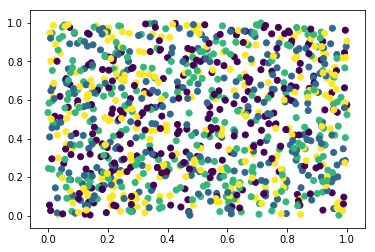

In [36]:
import matplotlib.cm as cm
plt.figure()
plt.scatter(X[:,0], X[:,1], c=X[:,2])
plt.show()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=9)

In [40]:
# Fit classifier with out-of-bag estimates
n_estimators = 1200
clf = ensemble.GradientBoostingClassifier(n_estimators=n_estimators, max_depth=3, subsample=0.5, learning_rate=0.01, 
                                          min_samples_leaf=1, random_state=3)

class sklearn.ensemble.GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’)

In [42]:
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1200, presort='auto', random_state=3,
              subsample=0.5, verbose=0, warm_start=False)

In [43]:
acc = clf.score(X_test, y_test)
print("Accuracy: {:.4f}".format(acc))

Accuracy: 0.6820


In [44]:
x = np.arange(n_estimators) + 1

In [45]:
def heldout_score(clf, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score

In [46]:
def cv_estimate(n_folds=3):
    cv = KFold(n=X_train.shape[0], n_folds=n_folds)
    cv_clf = ensemble.GradientBoostingClassifier(n_estimators=n_estimators, max_depth=3, subsample=0.5, 
                                                 learning_rate=0.01, min_samples_leaf=1, random_state=3)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv:
        cv_clf.fit(X_train[train], y_train[train])
        val_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    val_scores /= n_folds
    return val_scores

In [47]:
# Estimate best n_estimator using cross-validation
cv_score = cv_estimate(3)

In [50]:
print(cv_score)

[ 1.38206107  1.37672064  1.37078415 ...,  1.25115571  1.25151545
  1.25158562]


In [52]:
# Compute best n_estimator for test data
test_score = heldout_score(clf, X_test, y_test)
print(test_score)

[ 1.38176281  1.37597256  1.3712185  ...,  1.21232457  1.21208075
  1.2119003 ]


In [54]:
# negative cumulative sum of oob improvements

# oob_improvement_ : The improvement in loss (= deviance) on the out-of-bag samples relative to the previous iteration.
# oob_improvement_[0] is the improvement in loss of the first stage over the init estimator.

cumsum = -np.cumsum(clf.oob_improvement_)

In [55]:
# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]
print(oob_best_iter)

160


In [56]:
# min loss according to test (normalize such that first loss is 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

print(test_best_iter)

301


In [59]:
# min loss according to cv (normalize such that first loss is 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

print(cv_best_iter)

250


### Plot it

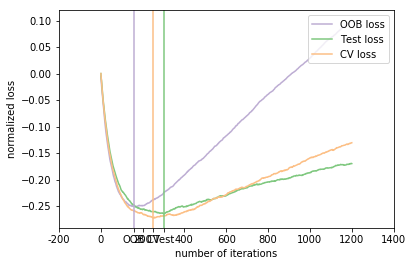

In [60]:
# color brew for the three curves
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))

# plot curves and vertical lines for best iterations
plt.plot(x, cumsum, label='OOB loss', color=oob_color)
plt.plot(x, test_score, label='Test loss', color=test_color)
plt.plot(x, cv_score, label='CV loss', color=cv_color)
plt.axvline(x=oob_best_iter, color=oob_color)
plt.axvline(x=test_best_iter, color=test_color)
plt.axvline(x=cv_best_iter, color=cv_color)

# add three vertical lines to xticks
xticks = plt.xticks()
xticks_pos = np.array(xticks[0].tolist() +
                      [oob_best_iter, cv_best_iter, test_best_iter])
xticks_label = np.array(list(map(lambda t: int(t), xticks[0])) +
                        ['OOB', 'CV', 'Test'])
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label)

plt.legend(loc='upper right')
plt.ylabel('normalized loss')
plt.xlabel('number of iterations')

plt.show()

The figure shows the cumulative sum of the negative OOB improvements as a function of the boosting iteration. As you can see, it tracks the test loss for the first hundred iterations but then diverges in a pessimistic way. The figure also shows the performance of 3-fold cross validation which usually gives a better estimate of the test loss but is computationally more demanding.